import

In [1]:
import numpy as np
import os
from sklearn.metrics import confusion_matrix
import seaborn as sn; sn.set(font_scale=1.4)
from sklearn.utils import shuffle           
import matplotlib.pyplot as plt             
import cv2                                 
import tensorflow as tf                
from tqdm import tqdm

In [2]:
class_names = ['Dent', 'Other', 'Rim', 'Scratch']
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}

nb_classes = len(class_names)

IMAGE_SIZE = (236,255)

loading the data

In [3]:
def load_data():
    """
        Load the data:
            - 14,034 images to train the network.
            - 3,000 images to evaluate how accurately the network learned to classify images.
    """
    
    datasets = ['output/train', 'output/val']
    output = []
    
    # Iterate through training and test sets
    for dataset in datasets:
        
        images = []
        labels = []
        
        print("Loading {}".format(dataset))
        
        # Iterate through each folder corresponding to a category
        for folder in os.listdir(dataset):
            label = class_names_label[folder]
            
            # Iterate through each image in our folder
            for file in tqdm(os.listdir(os.path.join(dataset, folder))):
                
                # Get the path name of the image
                img_path = os.path.join(os.path.join(dataset, folder), file)
                
                # Open and resize the img
                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, IMAGE_SIZE) 
                
                # Append the image and its corresponding label to the output
                images.append(image)
                labels.append(label)
                
        images = np.array(images, dtype = 'float32')
        labels = np.array(labels, dtype = 'int32')   
        
        output.append((images, labels))

    return output

In [4]:
(train_images, train_labels), (test_images, test_labels) = load_data()

Loading output/train


100%|██████████| 224/224 [00:00<00:00, 621.71it/s]


Loading output/val


100%|██████████| 56/56 [00:00<00:00, 442.48it/s]


In [5]:
train_images, train_labels = shuffle(train_images, train_labels, random_state=25)

explore the dataset

In [6]:
n_train = train_labels.shape[0]
n_test = test_labels.shape[0]

print ("Number of training examples: {}".format(n_train))
print ("Number of testing examples: {}".format(n_test))
print ("Each image is of size: {}".format(IMAGE_SIZE))

Number of training examples: 717
Number of testing examples: 180
Each image is of size: (236, 255)


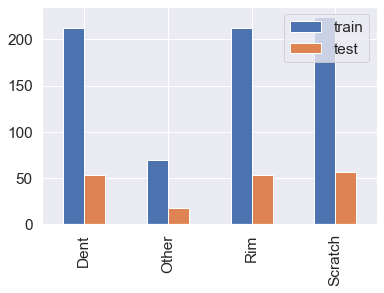

In [7]:
import pandas as pd

_, train_counts = np.unique(train_labels, return_counts=True)
_, test_counts = np.unique(test_labels, return_counts=True)
pd.DataFrame({'train': train_counts,
                    'test': test_counts}, 
             index=class_names
            ).plot.bar()
plt.show()

scale the data

In [8]:
train_images = train_images / 255.0 
test_images = test_images / 255.0

visualize the data

In [9]:
def display_random_image(class_names, images, labels):
    """
        Display a random image from the images array and its correspond label from the labels array.
    """
    
    index = np.random.randint(images.shape[0])
    plt.figure()
    plt.imshow(images[index])
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title('Image #{} : '.format(index) + class_names[labels[index]])
    plt.show()

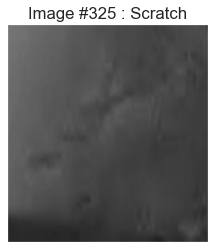

In [10]:
display_random_image(class_names, train_images, train_labels)

In [11]:
def display_examples(class_names, images, labels):
    """
        Display 25 images from the images array with its corresponding labels
    """
    
    fig = plt.figure(figsize=(10,10))
    fig.suptitle("Some examples of images of the dataset", fontsize=16)
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.binary)
        plt.xlabel(class_names[labels[i]])
    plt.show()

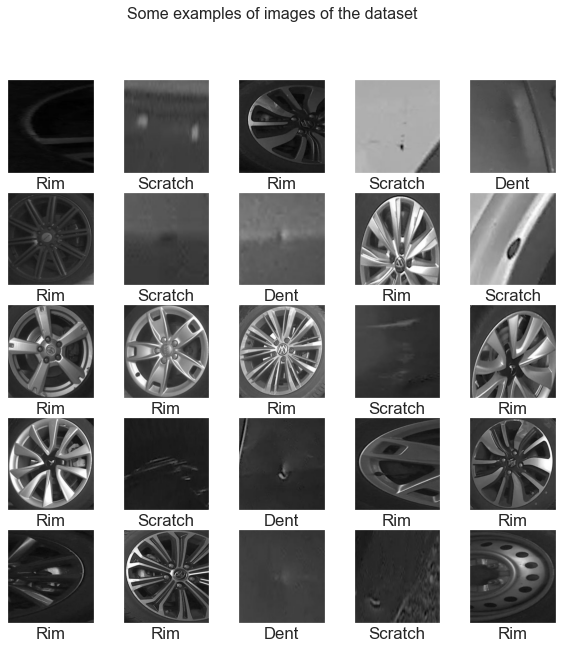

In [12]:
display_examples(class_names, train_images, train_labels)

build a simple model

Steps are:

- Build the model,
- Compile the model,
- Train / fit the data to the model,
- Evaluate the model on the testing set,
- Carry out an error analysis of our model.
- We can build an easy model composed of different layers such as:
    - Conv2D: (32 filters of size 3 by 3) The features will be "extracted" from the image.
    - MaxPooling2D: The images get half sized.
    - Flatten: Transforms the format of the images from a 2d-array to a 1d-array of 255 236 3 pixel values.
    - Relu : given a value x, returns max(x, 0).
    - Softmax: 6 neurons, probability that the image belongs to one of the classes.

In [13]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (255, 236, 3)), 
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(6, activation=tf.nn.softmax)
])

In [14]:
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

In [15]:
history = model.fit(train_images, train_labels, batch_size=128, epochs=20, validation_split = 0.2)

Epoch 1/20
5/5 [==============================] - 44s 6s/step - loss: 2.2741 - accuracy: 0.3944 - val_loss: 1.0220 - val_accuracy: 0.5903
Epoch 2/20
5/5 [==============================] - 30s 6s/step - loss: 1.1274 - accuracy: 0.5742 - val_loss: 1.1152 - val_accuracy: 0.4653
Epoch 3/20
5/5 [==============================] - 37s 6s/step - loss: 0.9996 - accuracy: 0.5375 - val_loss: 0.8914 - val_accuracy: 0.5486
Epoch 4/20
5/5 [==============================] - 28s 5s/step - loss: 0.7782 - accuracy: 0.6318 - val_loss: 0.7831 - val_accuracy: 0.6042
Epoch 5/20
5/5 [==============================] - 26s 5s/step - loss: 0.6543 - accuracy: 0.7592 - val_loss: 0.7694 - val_accuracy: 0.6389
Epoch 6/20
5/5 [==============================] - 24s 5s/step - loss: 0.6065 - accuracy: 0.7661 - val_loss: 0.7425 - val_accuracy: 0.6458
Epoch 7/20
5/5 [==============================] - 24s 5s/step - loss: 0.5406 - accuracy: 0.7661 - val_loss: 0.7183 - val_accuracy: 0.6806
Epoch 8/20
5/5 [==================

In [16]:
def plot_accuracy_loss(history):
    """
        Plot the accuracy and the loss during the training of the nn.
    """
    fig = plt.figure(figsize=(10,5))

    # Plot accuracy
    plt.subplot(221)
    plt.plot(history.history['accuracy'],'bo--', label = "acc")
    plt.plot(history.history['val_accuracy'], 'ro--', label = "val_acc")
    plt.title("train_acc vs val_acc")
    plt.ylabel("accuracy")
    plt.xlabel("epochs")
    plt.legend()

    # Plot loss function
    plt.subplot(222)
    plt.plot(history.history['loss'],'bo--', label = "loss")
    plt.plot(history.history['val_loss'], 'ro--', label = "val_loss")
    plt.title("train_loss vs val_loss")
    plt.ylabel("loss")
    plt.xlabel("epochs")

    plt.legend()
    plt.show()

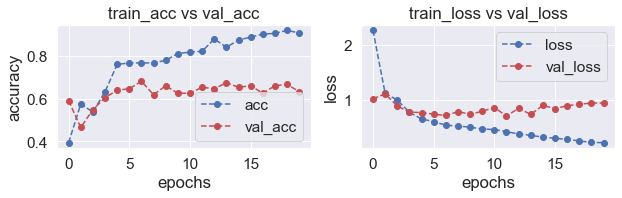

In [17]:
plot_accuracy_loss(history)

In [18]:
test_loss = model.evaluate(test_images, test_labels)

6/6 [==============================] - 2s 354ms/step - loss: 0.9708 - accuracy: 0.6389
